#### Importing Libraries

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore
import awswrangler as wr
import matplotlib.pyplot as plt
import nltk
import string
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm 
from sagemaker import clarify

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\hsohr\AppData\Local\sagemaker\sagemaker\config.yaml


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hsohr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hsohr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#getting bucket name
s3 = boto3.client('s3')
bucket = s3.list_buckets()
bucket_names = [bucket['Name'] for bucket in bucket['Buckets']]

for bucket_name in bucket_names:
    print(f"Bucket name: {bucket_name}")

In [3]:
# AWS credentials
aws_access_key = 'xxx'
aws_secret_access_key = 'xxx'
aws_region = 'us-east-2'

# S3 bucket and file information
bucket_name = 'xxx'

# Create an S3 client
s3 = boto3.client('s3', aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_access_key, region_name=aws_region)
  

#### 1. Getting raw datafrom from S3

In [5]:
!aws s3 ls s3://bucket_address/Data/IMDB_raw_reviews.csv

'aws' is not recognized as an internal or external command,
operable program or batch file.


#### 2. Copy dataset to local notebook

In [ ]:
!aws s3 cp s3://bucket_address/Data/IMDB_raw_reviews.csv IMDB_raw_reviews.csv

#### 3. Load dataset

In [228]:
df = pd.read_csv('IMDB_raw_reviews.csv')
df.head()

,review,rate
0,"""Carmencita"" is a short video of a woman danci...",1.0
1,"Like his other work, Autour d'une cabine, Char...",3.0
2,until this film came along the use of motion p...,NaN
3,"In 1891, Thomas Edison and his staff, led by W...",8.0
4,James J. Corbett (better known as Gentleman Ji...,7.0


#### 4. Data Preprocessing: labeling and cleaning null values

In [229]:
df['rate'].isna().sum()

6147

In [230]:
df = df.dropna()

In [231]:
# add a new column for labels
df['sentiment'] = -999

In [232]:
# Iterate through each row to assign sentiments based on ratings
for index, row in df.iterrows():
    rating = row['rate']
    if rating in {1, 2, 3}:
        df.loc[index, 'sentiment'] = -1
    elif rating in {7, 8, 9, 10}:
        df.loc[index, 'sentiment'] = 1
    elif rating in {4,5,6}:
        df.loc[index, 'sentiment'] = 0

In [233]:
df.head()

,review,rate,sentiment
0,"""Carmencita"" is a short video of a woman danci...",1.0,-1
1,"Like his other work, Autour d'une cabine, Char...",3.0,-1
3,"In 1891, Thomas Edison and his staff, led by W...",8.0,1
4,James J. Corbett (better known as Gentleman Ji...,7.0,1
5,"In this film, Fred Ott, an employee of Thomas ...",5.0,0


In [234]:
df_clean_labeled = df.drop(columns='rate')

In [235]:
df_clean_labeled

,review,sentiment
0,"""Carmencita"" is a short video of a woman danci...",-1
1,"Like his other work, Autour d'une cabine, Char...",-1
3,"In 1891, Thomas Edison and his staff, led by W...",1
4,James J. Corbett (better known as Gentleman Ji...,1
5,"In this film, Fred Ott, an employee of Thomas ...",0
...,...,...
38646,I just watched The Trial of the Catonsville Ni...,1
38647,TRILOGY OF SWORDSMANSHIP came as a bit of a su...,1
38648,"""Trinity and Sartana"" was originally released ...",-1
38649,You will also find my first review for the fil...,0


#### 4.1 Upload Clean dataset to S3

In [236]:
#Write it to a new CSV
df_clean_labeled.to_csv('df_clean_labeled.csv', 
                      index=False)

In [ ]:
#upload new data to s3
!aws s3 cp df_clean_labeled.csv s3://bucket_address/Data/

#### 5. EDA
* How many reviews per sentiment?

In [238]:
count_reviews_sentiment= df_clean_labeled.groupby(by=['sentiment']).count().reset_index()
count_reviews_sentiment

,sentiment,review
0,-1,4074
1,0,13016
2,1,15415


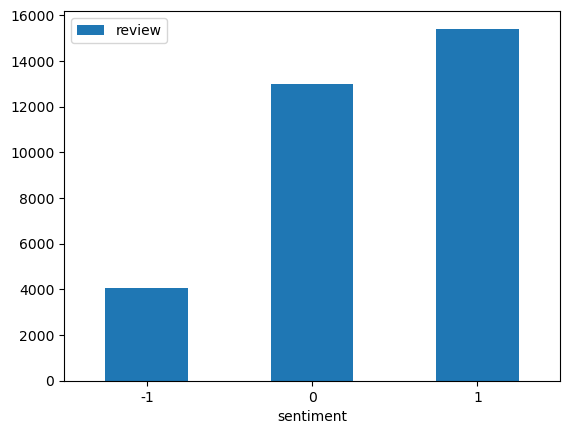

In [239]:
count_reviews_sentiment_plt = count_reviews_sentiment.plot(kind='bar', x='sentiment', y='review', rot=0)
# Do not change the figure name - it is used for grading purposes!
plt.savefig('sentiment_per_review.png', dpi=300)


In [240]:
#store the plot
!aws s3 cp count_reviews_sentiment_plt s3://bucket_address/Plots/


The user-provided path count_reviews_sentiment_plt does not exist.


In [ ]:
sess.upload_data(path='sentiment_per_review.png', bucket='bucket_address', key_prefix="images")

#### 6. Data Cleaning
  1. Remove irrelevant characters, punctuation
  2. Tokenization

In [242]:
#Remove stopwords and punctuations
def remove_stopwords_punctuation(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_words = []
    for word in word_tokens:
        # Remove stopwords and punctuation
        if word.lower() not in stop_words and word.lower() not in string.punctuation:
            # Remove double quotes
            word = re.sub(r'"', '', word)
            # Remove punctuation using regex
            word = re.sub(r'[^\w\s]', '', word)
            filtered_words.append(word)
    return ' '.join(filtered_words)
    
df_clean_labeled['clean_review'] = df_clean_labeled['review'].apply(remove_stopwords_punctuation_quotes)

In [244]:

new_df = pd.DataFrame({
    'raw_review': df_clean_labeled['review'].values,
    'clean_review': df_clean_labeled['clean_review'].values
})
new_df

,raw_review,clean_review
0,"""Carmencita"" is a short video of a woman danci...",Carmencita short video woman dancing obvious...
1,"Like his other work, Autour d'une cabine, Char...",Like work Autour dune cabine CharlesÉmile Reyn...
2,"In 1891, Thomas Edison and his staff, led by W...",1891 Thomas Edison staff led William K L Dicks...
3,James J. Corbett (better known as Gentleman Ji...,James J Corbett better known Gentleman Jim Cor...
4,"In this film, Fred Ott, an employee of Thomas ...",film Fred Ott employee Thomas Edison takes pin...
...,...,...
32500,I just watched The Trial of the Catonsville Ni...,watched Trial Catonsville Nine first time wait...
32501,TRILOGY OF SWORDSMANSHIP came as a bit of a su...,TRILOGY SWORDSMANSHIP came bit surprise knowin...
32502,"""Trinity and Sartana"" was originally released ...",Trinity Sartana originally released back 197...
32503,You will also find my first review for the fil...,also find first review film Solange leben mir...


In [246]:
df_clean_labeled = df_clean_labeled.drop(columns='review')

In [247]:
df_clean_labeled

,sentiment,clean_review
0,-1,Carmencita short video woman dancing obvious...
1,-1,Like work Autour dune cabine CharlesÉmile Reyn...
3,1,1891 Thomas Edison staff led William K L Dicks...
4,1,James J Corbett better known Gentleman Jim Cor...
5,0,film Fred Ott employee Thomas Edison takes pin...
...,...,...
38646,1,watched Trial Catonsville Nine first time wait...
38647,1,TRILOGY SWORDSMANSHIP came bit surprise knowin...
38648,-1,Trinity Sartana originally released back 197...
38649,0,also find first review film Solange leben mir...


In [248]:
#Tokenization
df_clean_labeled['tokenized_review'] = df_clean_labeled['clean_review'].apply(lambda x: word_tokenize(x))

In [249]:
# Display the DataFrame with the tokenized reviews
df_clean_labeled[['tokenized_review', 'clean_review']]

,tokenized_review,clean_review
0,"[Carmencita, short, video, woman, dancing, obv...",Carmencita short video woman dancing obvious...
1,"[Like, work, Autour, dune, cabine, CharlesÉmil...",Like work Autour dune cabine CharlesÉmile Reyn...
3,"[1891, Thomas, Edison, staff, led, William, K,...",1891 Thomas Edison staff led William K L Dicks...
4,"[James, J, Corbett, better, known, Gentleman, ...",James J Corbett better known Gentleman Jim Cor...
5,"[film, Fred, Ott, employee, Thomas, Edison, ta...",film Fred Ott employee Thomas Edison takes pin...
...,...,...
38646,"[watched, Trial, Catonsville, Nine, first, tim...",watched Trial Catonsville Nine first time wait...
38647,"[TRILOGY, SWORDSMANSHIP, came, bit, surprise, ...",TRILOGY SWORDSMANSHIP came bit surprise knowin...
38648,"[Trinity, Sartana, originally, released, back,...",Trinity Sartana originally released back 197...
38649,"[also, find, first, review, film, Solange, leb...",also find first review film Solange leben mir...


In [250]:
df_clean_labeled_tokenized = df_clean_labeled.drop(columns='clean_review')

In [251]:
df_clean_labeled_tokenized

,sentiment,tokenized_review
0,-1,"[Carmencita, short, video, woman, dancing, obv..."
1,-1,"[Like, work, Autour, dune, cabine, CharlesÉmil..."
3,1,"[1891, Thomas, Edison, staff, led, William, K,..."
4,1,"[James, J, Corbett, better, known, Gentleman, ..."
5,0,"[film, Fred, Ott, employee, Thomas, Edison, ta..."
...,...,...
38646,1,"[watched, Trial, Catonsville, Nine, first, tim..."
38647,1,"[TRILOGY, SWORDSMANSHIP, came, bit, surprise, ..."
38648,-1,"[Trinity, Sartana, originally, released, back,..."
38649,0,"[also, find, first, review, film, Solange, leb..."


In [252]:
#Write it to a new CSV
df_clean_labeled_tokenized.to_csv('df_clean_labeled_tokenized.csv', 
                      index=False)

In [ ]:
#upload new datato s3
!aws s3 cp df_clean_labeled_tokenized.csv bucket_address/Data/